In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['test.csv.zip', 'train.csv', 'train.csv.zip', 'test.csv', '.DS_Store', 'embeddings']


In [2]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, Concatenate, Lambda, Flatten
from keras.layers import GlobalMaxPool1D
from keras.models import Model


import tqdm

Using TensorFlow backend.


# Embeddings

In [3]:
MAX_SEQUENCE_LENGTH = 60
MAX_WORDS = 45000
EMBEDDINGS_TRAINED_DIMENSIONS = 100
EMBEDDINGS_LOADED_DIMENSIONS = 300

## Pretrained
Load the embeddings

In [4]:
def load_embeddings(file):
    embeddings = {}
    with open(file) as f:
        def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
        embeddings = dict(get_coefs(*line.split(" ")) for line in f)
        
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [5]:
# custom_embeddings = train_w2v(question_texts, epochs=5)
pretrained_embeddings = load_embeddings("../input/embeddings/glove.840B.300d/glove.840B.300d.txt")


Found 2196016 word vectors.


In [6]:
from collections import defaultdict

def create_embedding_weights(tokenizer, embeddings, dimensions):
    not_embedded = defaultdict(int)
    
    word_index = tokenizer.word_index
    words_count = min(len(word_index), MAX_WORDS)
    embeddings_matrix = np.zeros((words_count, dimensions))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        if word not in embeddings:
            not_embedded[word] = not_embedded[word] + 1
            continue
        embedding_vector = embeddings[word]
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
            
    print(sorted(not_embedded, key=not_embedded.get)[:10])
    return embeddings_matrix

# Data
Load the data.

In [7]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

In [8]:
BATCH_SIZE = 512
Q_FRACTION = 1
questions = df_train.sample(frac=Q_FRACTION)
question_texts = questions["question_text"].fillna("_na_").values
question_targets = questions["target"].values
test_texts = df_test["question_text"].fillna("_na_").values

print(f"Working on {len(questions)} questions")

Working on 1306122 questions


In [9]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(list(df_train["question_text"].values))

## Tokenize and pad

In [10]:
def tokenize_and_pad(texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

train_X, test_X = [tokenize_and_pad(texts) for texts in [question_texts, test_texts]]

## Pretrained embedding weights

In [11]:
# custom_emb_weights = create_embedding_weights(tokenizer, custom_embeddings, EMBEDDINGS_TRAINED_DIMENSIONS)
pretrained_emb_weights = create_embedding_weights(tokenizer, pretrained_embeddings, EMBEDDINGS_LOADED_DIMENSIONS)

["what's", "i'm", "isn't", "i've", 'i’m', "you've", 'don’t', "aren't", 'what’s', "won't"]


# Model

# Model evaluation




In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

THRESHOLD = 0.35

class EpochMetricsCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.precisions = []
        self.accuracies = []
        
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.validation_data[0])
        predictions = (predictions > THRESHOLD).astype(int)
        predictions = np.asarray(predictions)
        targets = self.validation_data[1]
        f1 = metrics.f1_score(targets, predictions)
        precision = metrics.precision_score(targets, predictions)
        accuracy = metrics.accuracy_score(targets, predictions)

        print(" - F1 score: {0:.4f}, Precision: {1:.4f}, Accuracy: {2:.4f}"
              .format(f1, precision, accuracy))
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.accuracies.append(accuracy)
        return
    
def display_model_history(history):
    data = pd.DataFrame(data={'Train': history.history['loss'], 'Test': history.history['val_loss']})
    ax = sns.lineplot(data=data, palette="pastel", linewidth=2.5, dashes=False)
    ax.set(xlabel='Epoch', ylabel='Loss', title='Loss')
    plt.show()

def display_model_epoch_metrics(epoch_callback):
    fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey=False)
    a1, a2, a3 = axes
    
    a1.set_title('F1')
    a1.set(xlabel='Epoch', title='F1')
    sns.lineplot(data=pd.DataFrame(data={'F1': epoch_callback.f1s}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a1, legend=False)

    a2.set_title('Precision')
    a2.set(xlabel='Epoch', title='Precision')
    sns.lineplot(data=pd.DataFrame(data={'Precision': epoch_callback.precisions}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a2, legend=False)

    a3.set_title('Accuracy')
    a3.set(xlabel='Epoch', title='Accuracy')
    sns.lineplot(data=pd.DataFrame(data={'Accuracy': epoch_callback.accuracies}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a3, legend=False)

    plt.show()

# Training
Train the model. Also, experiment with different versions

## Alternative models

In [13]:
from keras.layers import Reshape, Conv2D, MaxPool2D, Flatten, Dropout, Dense

def make_model(filter_size, num_filters):
    tokenized_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="tokenized_input")
    
    pretrained = Embedding(MAX_WORDS,
                           EMBEDDINGS_LOADED_DIMENSIONS,
                           weights=[pretrained_emb_weights],
                           trainable=False)(tokenized_input)

    pretrained = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDINGS_LOADED_DIMENSIONS, 1))(pretrained)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_size, EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_size + 1, 1))(conv_0)

    d0 = Dense(4)(maxpool_0)

    x = Flatten()(d0)
    x = Dropout(0.1)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[tokenized_input], outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

CNN MODEL WITH FILTER OF SIZE 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 60, 300)           13500000  
_________________________________________________________________
reshape_9 (Reshape)          (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 1, 42)         12642     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 42)          0         
_________________________________________________________________
dense_17 (Dense)             (None, 1, 1, 4)           172       
_________________________________________________________________
flatten_9 (Flatten)          (None, 4)      

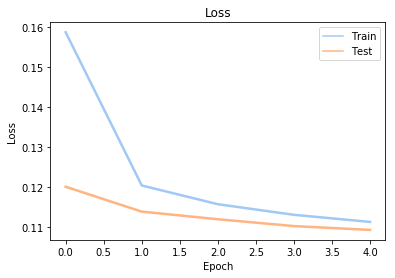

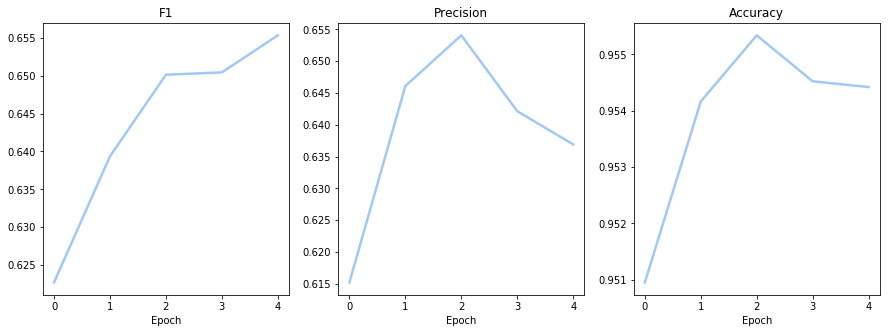

56370/56370 [==============================] - 1s 19us/step
CNN MODEL WITH FILTER OF SIZE 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_10 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 1, 42)         63042     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_19 (Dense)             (None, 1, 1, 4)           172       
__________________________________________________

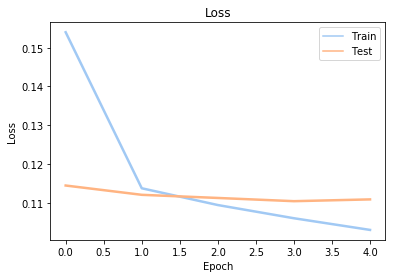

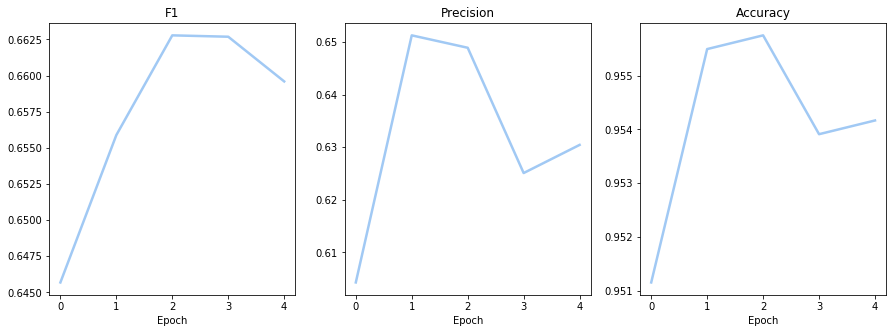

56370/56370 [==============================] - 4s 66us/step
CNN MODEL WITH FILTER OF SIZE 13
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_11 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 1, 42)         163842    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_21 (Dense)             (None, 1, 1, 4)           172       
_________________________________________________

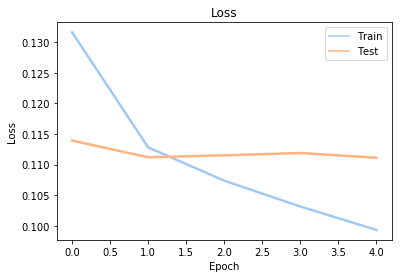

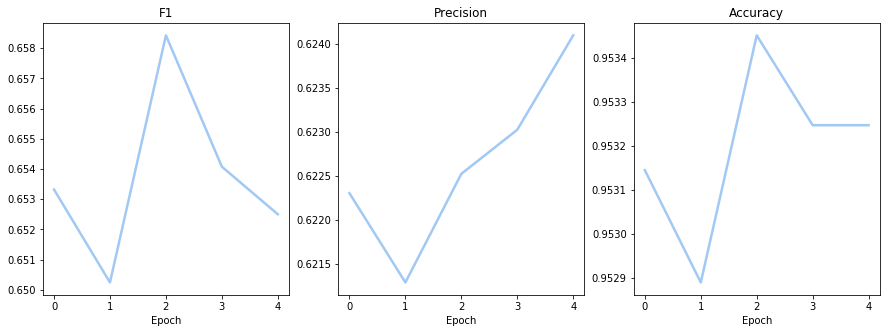

56370/56370 [==============================] - 8s 146us/step
CNN MODEL WITH FILTER OF SIZE 33
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_12 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 1, 42)         415842    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 1, 4)           172       
________________________________________________

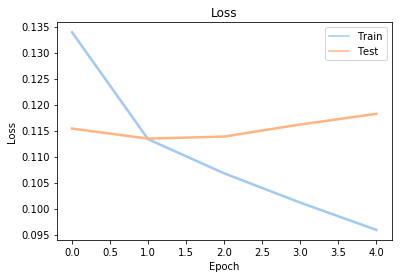

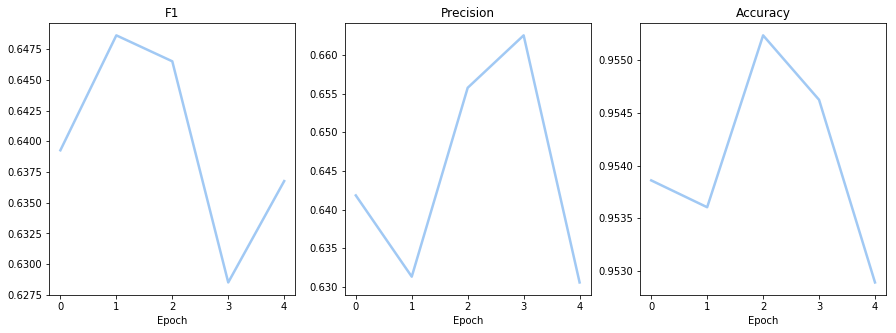

56370/56370 [==============================] - 13s 233us/step


In [17]:
filter_sizes = [1, 5, 13, 33]
num_filters = 42

predictions = []

for f in filter_sizes:
    print("CNN MODEL WITH FILTER OF SIZE {0}".format(f))
    epoch_callback = EpochMetricsCallback()
    model = make_model(f, num_filters)
    history = model.fit(
        x=[train_X],
        y=question_targets,
        batch_size=1536, epochs=5, callbacks=[epoch_callback], validation_split=0.015,
        verbose=2)
    display_model_history(history)
    display_model_epoch_metrics(epoch_callback)

    pred_test = model.predict([test_X], batch_size=1024, verbose=1)
    predictions.append(pred_test)

# Results

In [15]:
# test_word_tokens = pad_sequences(tokenizer.texts_to_sequences(test_texts),
#                        maxlen=MAX_SEQUENCE_LENGTH)
# pred_test = model.predict([test_word_tokens], batch_size=1024, verbose=1)
avg = np.average(predictions, axis=0)

pred_test = (avg > THRESHOLD).astype(int) 

df_out = pd.DataFrame({"qid":df_test["qid"].values})
df_out['prediction'] = pred_test
df_out.to_csv("submission.csv", index=False)